In [ ]:
!pip install transformers[sentencepiece]
!pip install wandb

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 61 kB 518 kB/s 
     |████████████████████████████████| 596 kB 33.2 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 1.2 MB 47.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 180 kB 38.0 MB/s 
     |████████████████████████████████| 140 kB 38.3 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=b15a42e6e4f7169caab51987d0492489632d755811d24a5b59e635a324d3287a
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca

In [ ]:
import gc
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import json
from urllib.request import urlopen
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# Setup device

device_string = 'cuda' if torch.cuda.is_available() else 'cpu'
device_hf = 0 if torch.cuda.is_available() else -1
device = torch.device(device_string)
print("Device:", device)
NUM_WORKERS = 0

Device: cuda


In [ ]:
# Setup wandb

wandb.login()
%env WANDB_PROJECT=annotype_text_classification

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=annotype_text_classification


In [ ]:
# Config

IGNORED_CLASSES = [] # e.g. set it to ['sentiment'] to remove the objects with the type of sentiment, from the databset
MODEL_NAME = 'bert-base-uncased'
INPUT_TYPE = 'TEXT_HEAD' # Possible values: 'TEXT_HEAD', 'TEXT_ONLY', 'HEAD_ONLY'
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 64
LOGGING_STEPS = 500
EVAL_STRATEGY = 'steps'
SAVE_STRATEGY = 'steps'
WEIGHT_DECAY = 0.1
LOAD_BEST_MODEL_AT_END = True
NUM_TRAIN_EPOCHS = 10
CALLBACKS = [EarlyStoppingCallback(4)]
SEED = 0
DATA = 'MPQA2.0_v211202'
TEST_SIZE = 0.15
VAL_SIZE = 0.15 / (1 - TEST_SIZE)

In [ ]:
# Getting data & augmented data urls

data_name_to_google_drive_url = {
    'MPQA3.0_v211021': 'https://drive.google.com/file/d/1e-pDfZ2cyBzgD9MEerP9YCcDnPvIQuGo/view?usp=sharing',
    'MPQA2.0_v211202': 'https://drive.google.com/file/d/1hVFG4lA-6W9OtWurU5EQ3wDtlwtO7iLY/view?usp=sharing'
}

# Get direct download link
def get_download_url_from_google_drive_url(google_drive_url):
    return f'https://drive.google.com/uc?id={google_drive_url.split("/")[5]}&export=download'

# Data URL
google_drive_url = data_name_to_google_drive_url[DATA]
data_url = get_download_url_from_google_drive_url(google_drive_url)

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Preparing the dataset

In [ ]:
# Fetch the dataset

FETCH_FROM_WEB = True ### Set it to true, to download the datasets from github and google drive ###

if FETCH_FROM_WEB:
    response = urlopen(data_url)
    csds_collection = json.loads(response.read())
else:
    file_address = '..\\json2csds\\data.json'
    with open(file_address) as file:
        csds_collection = json.load(file)

In [ ]:
# Preparing inputs and targets

inputs_text = []
inputs_head = []
inputs_tuple_text_head = []
targets_annotype = []
doc_id = []
n_samples = 0

for csds_object in csds_collection['csds_objects']:
    if csds_object['annotation_type'] not in IGNORED_CLASSES:
        inputs_text += [csds_object['text']]
        inputs_head += [csds_object['head']]
        inputs_tuple_text_head += [(csds_object['text'], csds_object['head'])]
        targets_annotype += [csds_object['annotation_type']]
        doc_id += [csds_object['doc_id']]
        n_samples += 1

i = 128 # A sample
print(f'inputs and targets for {i+1}-th csds object (out of {n_samples}):')
print('inputs_text:\t\t', inputs_text[i])
print('inputs_head:\t\t', inputs_head[i])
print('inputs_tuple_text_head:\t', inputs_tuple_text_head[i])
print('targets_annotype:\t', targets_annotype[i])
print('doc_id:\t', doc_id[i])

inputs and targets for 129-th csds object (out of 23774):
inputs_text:		 President Bush described Iraq, Iran and North Korea as an ``axis 
of evil'' during his State of the Union address on Jan. 26.
inputs_head:		 an ``axis 
of evil
inputs_tuple_text_head:	 ("President Bush described Iraq, Iran and North Korea as an ``axis \nof evil'' during his State of the Union address on Jan. 26.", 'an ``axis \nof evil')
targets_annotype:	 expressive_subjectivity
doc_id:	 non_fbis/11.14.43-703


In [ ]:
docs = sorted(list(set(doc_id)))

In [ ]:
# Count the number of each annotation type and extract the labels

num_annotype = {}
for annotype in targets_annotype:
    num_annotype[annotype] = num_annotype.get(annotype, 0) + 1
print(sorted(num_annotype.items()))
classes = sorted(list(num_annotype.keys()))

[('agreement', 384), ('arguing', 2912), ('expressive_subjectivity', 13661), ('intention', 509), ('other_attitude', 939), ('sentiment', 5053), ('speculation', 316)]


In [ ]:
# Create a map for class ids and class names

classname2classid = {classes[i]:i for i in range(len(classes))}
classid2classname = {i:classes[i] for i in range(len(classes))}

In [ ]:
# Apply classname2classid mapping

y = [classname2classid[i] for i in targets_annotype]

In [ ]:
# Shuffle and split the dataset into training and validation sets

TEST_SPLIT_SEED = 0
VAL_SPLIT_SEED = 0

if TEST_SIZE != 0 :
    # Train Val Test -> Train Val | Test
    docs_train_val, docs_test = train_test_split(
        np.array(docs), test_size=TEST_SIZE,
        random_state=TEST_SPLIT_SEED, shuffle=True
    )
    docs_test = docs_test.tolist()
else:
    docs_train_val = np.array(docs)

# Train Val -> Train | Val
docs_train, docs_val = train_test_split(
    docs_train_val, test_size=VAL_SIZE,
    random_state=VAL_SPLIT_SEED, shuffle=True
)

docs_train = docs_train.tolist()
docs_val   = docs_val.tolist()

In [ ]:
# Prepare X and y

X_train_text = []
X_train_head = []
X_val_text = []
X_val_head = []
X_test_text = []
X_test_head = []

y_train = []
y_val = []
y_test = []

for i in range(n_samples):
    if doc_id[i] in docs_train:
        X_train_text.append(inputs_text[i])
        X_train_head.append(inputs_head[i])
        y_train.append(y[i])
    elif doc_id[i] in docs_val:
        X_val_text.append(inputs_text[i])
        X_val_head.append(inputs_head[i])
        y_val.append(y[i])
    elif doc_id[i] in docs_test:
        X_test_text.append(inputs_text[i])
        X_test_head.append(inputs_head[i])
        y_test.append(y[i])

In [ ]:
print('Train size:\t\t', len(X_train_text))
print('Validation size:\t', len(X_val_text))
print('Test size:\t\t', len(X_test_text))

Train size:		 16856
Validation size:	 3500
Test size:		 3418


# Preparing the model and torch dataset

In [ ]:
# Load the model, tokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(classes), resume_download=True, ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Tokenize the inputs

if INPUT_TYPE == 'TEXT_HEAD':
    X_train_tokenized = tokenizer(X_train_text, X_train_head, truncation=True)
    X_val_tokenized   = tokenizer(X_val_text,   X_val_head,   truncation=True)
    if TEST_SIZE > 0:
        X_test_tokenized = tokenizer(X_test_text, X_test_head, truncation=True)

if INPUT_TYPE == 'TEXT_ONLY':
    X_train_tokenized = tokenizer(X_train_text, truncation=True)
    X_val_tokenized   = tokenizer(X_val_text,   truncation=True)
    if TEST_SIZE > 0:
        X_test_tokenized = tokenizer(X_test_text, truncation=True)

if INPUT_TYPE == 'HEAD_ONLY':
    X_train_tokenized = tokenizer(X_train_head, truncation=True)
    X_val_tokenized   = tokenizer(X_val_head,   truncation=True)
    if TEST_SIZE > 0:
        X_test_tokenized = tokenizer(X_test_head, truncation=True)

In [ ]:
# Find the largest input size

t = 0
for i in X_train_tokenized['input_ids']:
    t = max(t, len(i))
for i in X_val_tokenized['input_ids']:
    t = max(t, len(i))
print("Maximum input length:", t)

Maximum input length: 188


In [ ]:
# Create torch dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
# Data collator

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Metrics

def compute_metrics(pred):
    targets = pred.label_ids
    preds = pred.predictions.argmax(-1)
    labels = [i for i in range(len(classes))] # [0, 1, 2, ..., len(classes)-1]
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, labels=labels, zero_division=0, average='weighted'
    )
    precision_list, recall_list, f1_list, _ = precision_recall_fscore_support(
        targets, preds, labels=labels, zero_division=0
    )
    acc = accuracy_score(targets, preds)
    decimals = 4
    return {
        'accuracy': acc,
        'f1': np.around(f1, decimals),
        'precision': np.around(precision, decimals),
        'recall': np.round(recall, decimals),
        'f1-list': np.around(f1_list, decimals).tolist(),
        'precision-list': np.around(precision_list, decimals).tolist(),
        'recall-list': np.round(recall_list, decimals).tolist(),
    }

In [ ]:
# Training Arguments

training_args = TrainingArguments(
    output_dir = 'models/pretrain_'+DATA+'_'+MODEL_NAME+'_'+INPUT_TYPE+'_'+str(SEED),
    overwrite_output_dir = True,
    per_device_train_batch_size = TRAIN_BATCH_SIZE,
    per_device_eval_batch_size = EVAL_BATCH_SIZE,
    evaluation_strategy = EVAL_STRATEGY,
    logging_steps = LOGGING_STEPS,
    save_strategy = SAVE_STRATEGY,
    save_steps = LOGGING_STEPS,
    save_total_limit = 2,
    weight_decay = WEIGHT_DECAY,
    num_train_epochs = NUM_TRAIN_EPOCHS,
    load_best_model_at_end = LOAD_BEST_MODEL_AT_END,
    dataloader_num_workers = NUM_WORKERS,
    seed = SEED,
    report_to = 'wandb'
)

# Train

In [ ]:
# Free some space

if 'trainer' in globals():
    del trainer
torch.cuda.empty_cache()
gc.collect()

868

In [ ]:
# Setup trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    callbacks = CALLBACKS
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 16856
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10540
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: side (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1-list,Precision-list,Recall-list
500,0.901200,0.773779,0.731429,0.710500,0.713100,0.731400,"[0.5, 0.5123, 0.8505, 0.6545, 0.6119, 0.5612, 0.0]","[0.6667, 0.5279, 0.7738, 0.8571, 0.7791, 0.6857, 0.0]","[0.4, 0.4976, 0.9441, 0.5294, 0.5038, 0.475, 0.0]"
1000,0.727200,0.698678,0.750286,0.734000,0.741700,0.750300,"[0.4935, 0.5339, 0.8553, 0.6949, 0.6459, 0.5986, 0.5349]","[0.5938, 0.6156, 0.7786, 0.82, 0.6694, 0.7418, 0.575]","[0.4222, 0.4713, 0.9487, 0.6029, 0.6241, 0.5017, 0.5]"
1500,0.558000,0.729238,0.747143,0.741900,0.742500,0.747100,"[0.5185, 0.5538, 0.8595, 0.697, 0.6121, 0.6189, 0.4727]","[0.5833, 0.5599, 0.8268, 0.7188, 0.5811, 0.6952, 0.4062]","[0.4667, 0.5478, 0.8949, 0.6765, 0.6466, 0.5576, 0.5652]"
2000,0.558100,0.665744,0.755429,0.747300,0.752800,0.755400,"[0.5316, 0.5925, 0.8614, 0.7302, 0.6795, 0.5984, 0.575]","[0.6176, 0.549, 0.817, 0.7931, 0.6984, 0.724, 0.6765]","[0.4667, 0.6435, 0.9109, 0.6765, 0.6617, 0.5099, 0.5]"
2500,0.434000,0.737531,0.753143,0.744900,0.753000,0.753100,"[0.5526, 0.6074, 0.8626, 0.748, 0.6241, 0.5853, 0.5679]","[0.6774, 0.5446, 0.8212, 0.8364, 0.6241, 0.7238, 0.6571]","[0.4667, 0.6866, 0.9083, 0.6765, 0.6241, 0.4913, 0.5]"
3000,0.423700,0.731359,0.757429,0.752000,0.752100,0.757400,"[0.5714, 0.577, 0.861, 0.7521, 0.6581, 0.6247, 0.5895]","[0.8, 0.59, 0.8266, 0.898, 0.7624, 0.6577, 0.5714]","[0.4444, 0.5646, 0.8985, 0.6471, 0.5789, 0.5949, 0.6087]"
3500,0.322800,0.801486,0.757714,0.748700,0.748400,0.757700,"[0.6279, 0.5429, 0.8626, 0.7667, 0.6387, 0.6264, 0.5361]","[0.6585, 0.5938, 0.8121, 0.8846, 0.7238, 0.691, 0.5098]","[0.6, 0.5, 0.9197, 0.6765, 0.5714, 0.5728, 0.5652]"


***** Running Evaluation *****
  Num examples = 3500
  Batch size = 64
Saving model checkpoint to models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-500
Configuration saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-500/config.json
Model weights saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3500
  Batch size = 64
Saving model checkpoint to models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-1000
Configuration saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-1000/config.json
Model weights saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3500
  Batch size = 64
Saving model checkpoint to models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-1500
Configurati

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1-list,Precision-list,Recall-list
500,0.901200,0.773779,0.731429,0.710500,0.713100,0.731400,"[0.5, 0.5123, 0.8505, 0.6545, 0.6119, 0.5612, 0.0]","[0.6667, 0.5279, 0.7738, 0.8571, 0.7791, 0.6857, 0.0]","[0.4, 0.4976, 0.9441, 0.5294, 0.5038, 0.475, 0.0]"
1000,0.727200,0.698678,0.750286,0.734000,0.741700,0.750300,"[0.4935, 0.5339, 0.8553, 0.6949, 0.6459, 0.5986, 0.5349]","[0.5938, 0.6156, 0.7786, 0.82, 0.6694, 0.7418, 0.575]","[0.4222, 0.4713, 0.9487, 0.6029, 0.6241, 0.5017, 0.5]"
1500,0.558000,0.729238,0.747143,0.741900,0.742500,0.747100,"[0.5185, 0.5538, 0.8595, 0.697, 0.6121, 0.6189, 0.4727]","[0.5833, 0.5599, 0.8268, 0.7188, 0.5811, 0.6952, 0.4062]","[0.4667, 0.5478, 0.8949, 0.6765, 0.6466, 0.5576, 0.5652]"
2000,0.558100,0.665744,0.755429,0.747300,0.752800,0.755400,"[0.5316, 0.5925, 0.8614, 0.7302, 0.6795, 0.5984, 0.575]","[0.6176, 0.549, 0.817, 0.7931, 0.6984, 0.724, 0.6765]","[0.4667, 0.6435, 0.9109, 0.6765, 0.6617, 0.5099, 0.5]"
2500,0.434000,0.737531,0.753143,0.744900,0.753000,0.753100,"[0.5526, 0.6074, 0.8626, 0.748, 0.6241, 0.5853, 0.5679]","[0.6774, 0.5446, 0.8212, 0.8364, 0.6241, 0.7238, 0.6571]","[0.4667, 0.6866, 0.9083, 0.6765, 0.6241, 0.4913, 0.5]"
3000,0.423700,0.731359,0.757429,0.752000,0.752100,0.757400,"[0.5714, 0.577, 0.861, 0.7521, 0.6581, 0.6247, 0.5895]","[0.8, 0.59, 0.8266, 0.898, 0.7624, 0.6577, 0.5714]","[0.4444, 0.5646, 0.8985, 0.6471, 0.5789, 0.5949, 0.6087]"
3500,0.322800,0.801486,0.757714,0.748700,0.748400,0.757700,"[0.6279, 0.5429, 0.8626, 0.7667, 0.6387, 0.6264, 0.5361]","[0.6585, 0.5938, 0.8121, 0.8846, 0.7238, 0.691, 0.5098]","[0.6, 0.5, 0.9197, 0.6765, 0.5714, 0.5728, 0.5652]"
4000,0.311400,0.815700,0.756000,0.741300,0.748500,0.756000,"[0.5333, 0.5722, 0.86, 0.7143, 0.6311, 0.5953, 0.5854]","[0.6667, 0.6137, 0.7871, 0.9091, 0.6937, 0.7317, 0.6667]","[0.4444, 0.5359, 0.9477, 0.5882, 0.5789, 0.5017, 0.5217]"


***** Running Evaluation *****
  Num examples = 3500
  Batch size = 64
Saving model checkpoint to models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-4000
Configuration saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-4000/config.json
Model weights saved in models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-3500] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from models/pretrain_MPQA2.0_v211202_bert-base-uncased_TEXT_HEAD_0/checkpoint-2000 (score: 0.665744423866272).


TrainOutput(global_step=4000, training_loss=0.5295182456970214, metrics={'train_runtime': 3076.6608, 'train_samples_per_second': 54.787, 'train_steps_per_second': 3.426, 'total_flos': 2723395678826400.0, 'train_loss': 0.5295182456970214, 'epoch': 3.8})

In [ ]:
pred = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 3500
  Batch size = 64


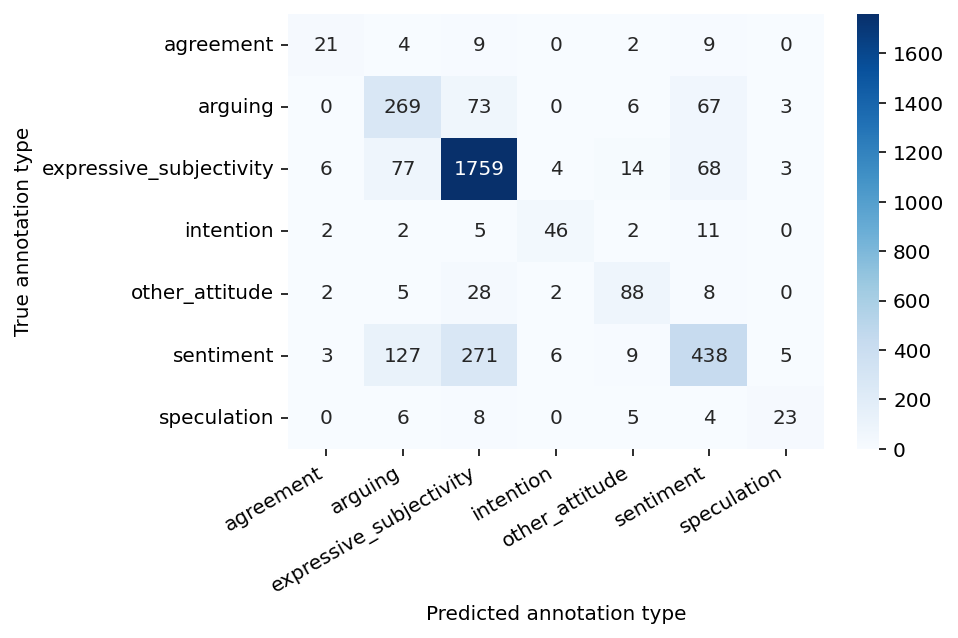

In [ ]:
# Show confusion matrix

targets = pred.label_ids
preds = pred.predictions.argmax(-1)

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True annotation type')
    plt.xlabel('Predicted annotation type');

cm = confusion_matrix(targets, preds)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

In [ ]:
wandb.finish()

eval/accuracy,▁▆▅▇▇███
eval/f1,▁▅▆▇▇█▇▆
eval/loss,▆▃▄▁▄▄▇█
eval/precision,▁▆▆███▇▇
eval/recall,▁▆▅▇▇███
eval/runtime,▁▂▄█▆▅▃▄
eval/samples_per_second,█▇▅▁▃▄▆▅
eval/steps_per_second,█▆▆▁▃▃▆▆
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▄▃▂▁
